In [1]:
import torch
from torch import nn
import numpy as np
import scipy
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
from lib import forward_diffusion, reverse_diffusion, make_schedule, DDPM


Two moons distribution

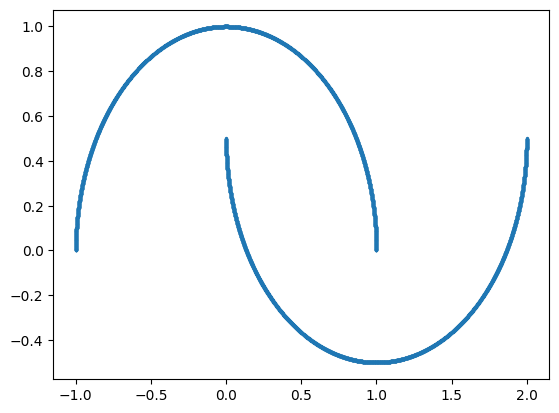

In [2]:
X_train, y_train = make_moons(n_samples=10000) #make_swiss_roll(n_samples=10000) 
#X_train = X_train[:,[0,2]]
plt.scatter(X_train[:,0],X_train[:,1],s=2)


Text(0.5, 0, 'rvar')

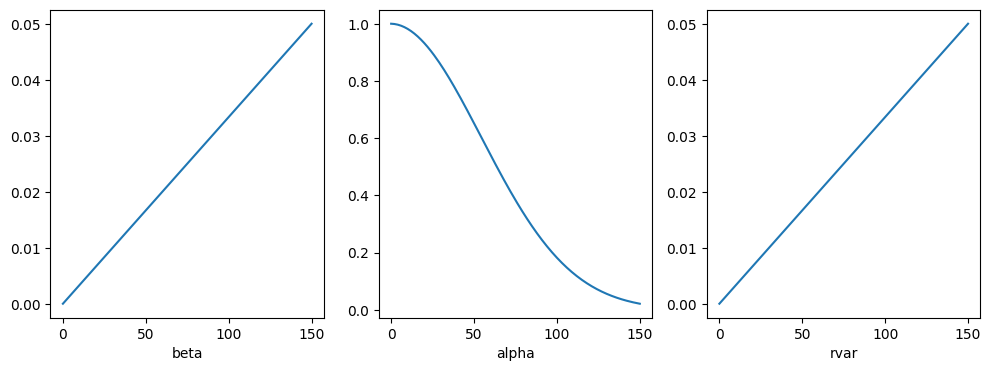

In [3]:
T = 150
schedule = make_schedule(scheme='linear', rvar='beta', T=T)
f, ax = plt.subplots(ncols=3,figsize=(12,4))
ax[0].plot(np.arange(start=0,stop=T+1),schedule['beta'])
ax[0].set_xlabel('beta')
ax[1].plot(np.arange(start=0,stop=T+1),schedule['alpha'])
ax[1].set_xlabel('alpha')
ax[2].plot(np.arange(start=0,stop=T+1),schedule['rvar'])
ax[2].set_xlabel('rvar')
#print(schedule['alpha'])

In [4]:
class simpleMLP_twomoons(torch.nn.Module):
    def __init__(self, ):
        super().__init__()    
        #self.model = nn.Sequential(nn.Linear(3,16),nn.ReLU(),nn.Linear(16,64),nn.ReLU(),nn.Linear(64,256),nn.ReLU(),nn.Linear(256,16),nn.ReLU(),nn.Linear(16,2)) 
        self.model1 = nn.Sequential(nn.Linear(2,32),nn.ReLU(),nn.Linear(32,64),nn.ReLU(),nn.Linear(64,16))
        self.model2 = nn.Sequential(nn.Linear(1,32),nn.ReLU(),nn.Linear(32,64),nn.ReLU(),nn.Linear(64,16))
        self.model3 = nn.Sequential(nn.Linear(32,32),nn.ReLU(),nn.Linear(32,16),nn.ReLU(),nn.Linear(16,2))
    def forward(self, x, t):
        #print(t.dtype, t.size())
        #t_onehot = torch.nn.functional.one_hot(t-1,num_classes=T)
        #x_t = torch.cat((x,( (t-(T/2))/T).unsqueeze(-1)),-1)
        x = self.model1(x)
        t = self.model2(( (t-(T/2))/T).unsqueeze(-1))
        x_t = torch.cat((x,t),-1)
        return self.model3(x_t)

model = simpleMLP_twomoons()
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=False,cuda=False)

In [5]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
X_train_torch = torch.Tensor(np.asarray(X_train,dtype=np.float32))
print(X_train_torch.shape)
num_epochs = 300
batch_size = 100
dataloader = torch.utils.data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=True)

for epoch in range(1,num_epochs+1):
    LOSS = 0
    ITER = 0
    for data_x in dataloader:
        optimizer.zero_grad()
        loss = ddpm_model.run_step(data_x)
        loss.backward()
        optimizer.step()
        LOSS += loss.item()
        ITER += 1
    print(f"epoch = {epoch}, loss = {LOSS/ITER}")    

torch.Size([10000, 2])
epoch = 1, loss = 0.8142985862493515
epoch = 2, loss = 0.3988343732059002
epoch = 3, loss = 0.34080271393060685
epoch = 4, loss = 0.33875188797712324
epoch = 5, loss = 0.3333150129020214
epoch = 6, loss = 0.33266321271657945
epoch = 7, loss = 0.32437321573495864
epoch = 8, loss = 0.3348170025646687
epoch = 9, loss = 0.3243149122595787
epoch = 10, loss = 0.3212582263350487
epoch = 11, loss = 0.3232687252759934
epoch = 12, loss = 0.31916189402341844
epoch = 13, loss = 0.32221310168504713
epoch = 14, loss = 0.3166451857984066
epoch = 15, loss = 0.31905085101723674
epoch = 16, loss = 0.3208516484498978
epoch = 17, loss = 0.3061882670223713
epoch = 18, loss = 0.3195121020078659
epoch = 19, loss = 0.3216883111000061
epoch = 20, loss = 0.31619424775242805
epoch = 21, loss = 0.3275980325043201
epoch = 22, loss = 0.31788903996348383
epoch = 23, loss = 0.326741070151329
epoch = 24, loss = 0.31912297204136847
epoch = 25, loss = 0.31177626341581344
epoch = 26, loss = 0.31900

/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/research/ddpm_base/lib.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  x_inp = torch.Tensor([x])


Text(0.5, 0, 'predicted two moons distribution')

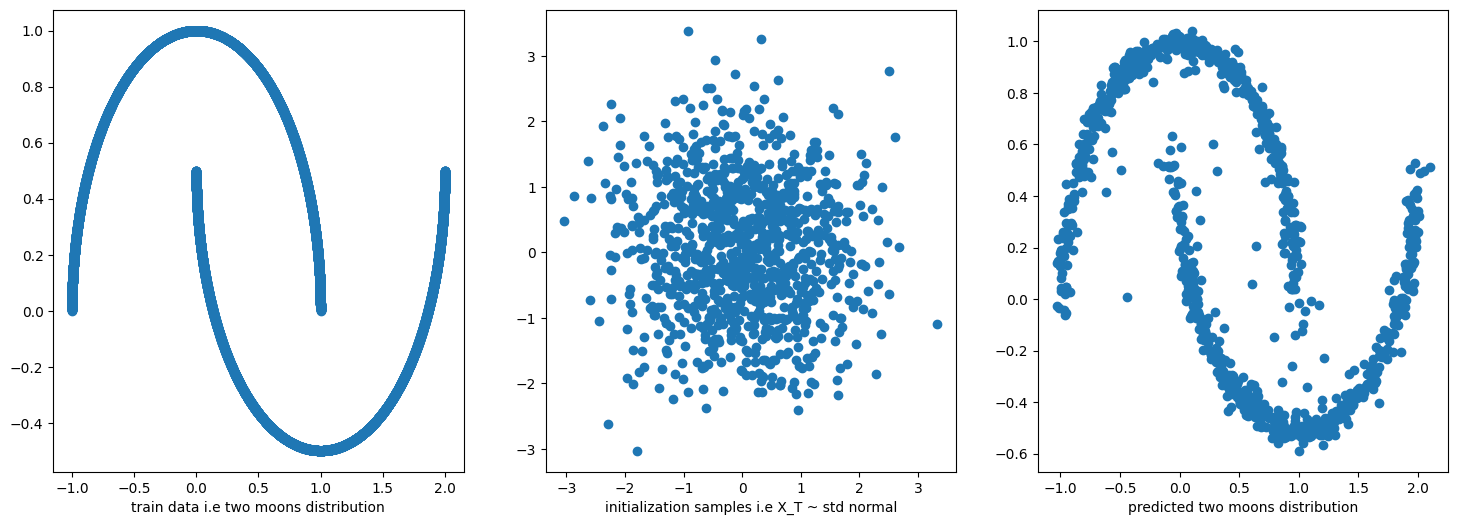

In [6]:
z = np.random.normal(loc=0, scale=1.0, size=(1000,2))
f, ax = plt.subplots(ncols=3, figsize=(18,6))
ax[0].scatter(X_train[:,0],X_train[:,1])
ax[0].set_xlabel('train data i.e two moons distribution')
ax[1].scatter(z[:,0],z[:,1])
ax[1].set_xlabel('initialization samples i.e X_T ~ std normal')
pred_samples = []
for sample_id in range(len(z)):
    x = z[sample_id]
    for t in range(0,T):
        x = reverse_diffusion(ddpm_model=ddpm_model, x=x, t_curr=T-t, cuda=False, schedule=schedule, onlymean=False)
        assert x.shape == (2,)
    pred_samples.append(x)
pred_samples = np.stack(pred_samples,axis=0)
assert pred_samples.shape == z.shape
ax[2].scatter(pred_samples[:,0],pred_samples[:,1])
ax[2].set_xlabel('predicted two moons distribution') 

2D projected Swiss roll distribution

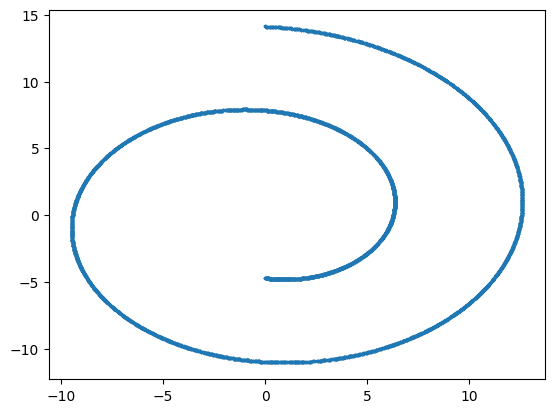

In [7]:
X_train, y_train = make_swiss_roll(n_samples=10000) 
X_viztrain = X_train[:,[0,2]]
plt.scatter(X_viztrain[:,0],X_viztrain[:,1],s=2)


In [8]:
class simpleMLP_swissroll(torch.nn.Module):
    def __init__(self, ):
        super().__init__()    
        #self.model = nn.Sequential(nn.Linear(3,16),nn.ReLU(),nn.Linear(16,64),nn.ReLU(),nn.Linear(64,256),nn.ReLU(),nn.Linear(256,16),nn.ReLU(),nn.Linear(16,2)) 
        self.model1 = nn.Sequential(nn.Linear(3,32),nn.ReLU(),nn.Linear(32,64),nn.ReLU(),nn.Linear(64,16))
        self.model2 = nn.Sequential(nn.Linear(1,32),nn.ReLU(),nn.Linear(32,64),nn.ReLU(),nn.Linear(64,16))
        self.model3 = nn.Sequential(nn.Linear(32,32),nn.ReLU(),nn.Linear(32,16),nn.ReLU(),nn.Linear(16,3))
    def forward(self, x, t):
        #print(t.dtype, t.size())
        #t_onehot = torch.nn.functional.one_hot(t-1,num_classes=T)
        #x_t = torch.cat((x,( (t-(T/2))/T).unsqueeze(-1)),-1)
        x = self.model1(x)
        t = self.model2(( (t-(T/2))/T).unsqueeze(-1))
        x_t = torch.cat((x,t),-1)
        return self.model3(x_t)

model = simpleMLP_swissroll()
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=False,cuda=False)

In [9]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
X_train_torch = torch.Tensor(np.asarray(X_train,dtype=np.float32))
print(X_train_torch.shape)
num_epochs = 300
batch_size = 100
dataloader = torch.utils.data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=True)

for epoch in range(1,num_epochs+1):
    LOSS = 0
    ITER = 0
    for data_x in dataloader:
        optimizer.zero_grad()
        loss = ddpm_model.run_step(data_x)
        loss.backward()
        optimizer.step()
        LOSS += loss.item()
        ITER += 1
    print(f"epoch = {epoch}, loss = {LOSS/ITER}")    

torch.Size([10000, 3])
epoch = 1, loss = 0.9825867992639542
epoch = 2, loss = 0.9489482820034028
epoch = 3, loss = 0.92138969540596
epoch = 4, loss = 0.9073289579153061
epoch = 5, loss = 0.8952816784381866
epoch = 6, loss = 0.8961609214544296
epoch = 7, loss = 0.8880836218595505
epoch = 8, loss = 0.8735071456432343
epoch = 9, loss = 0.8538681828975677
epoch = 10, loss = 0.86113893866539
epoch = 11, loss = 0.8440065068006516
epoch = 12, loss = 0.8438358533382416
epoch = 13, loss = 0.8240373414754868
epoch = 14, loss = 0.8377292603254318
epoch = 15, loss = 0.819227699637413
epoch = 16, loss = 0.8256951850652695
epoch = 17, loss = 0.8091353756189347
epoch = 18, loss = 0.8323209452629089
epoch = 19, loss = 0.8102220183610916
epoch = 20, loss = 0.8124438095092773
epoch = 21, loss = 0.8117393815517425
epoch = 22, loss = 0.8121291118860244
epoch = 23, loss = 0.8093240320682525
epoch = 24, loss = 0.8054810917377472
epoch = 25, loss = 0.8012349325418472
epoch = 26, loss = 0.8001414930820465
epo

Text(0.5, 0, 'predicted 2D projected swiss roll distribution')

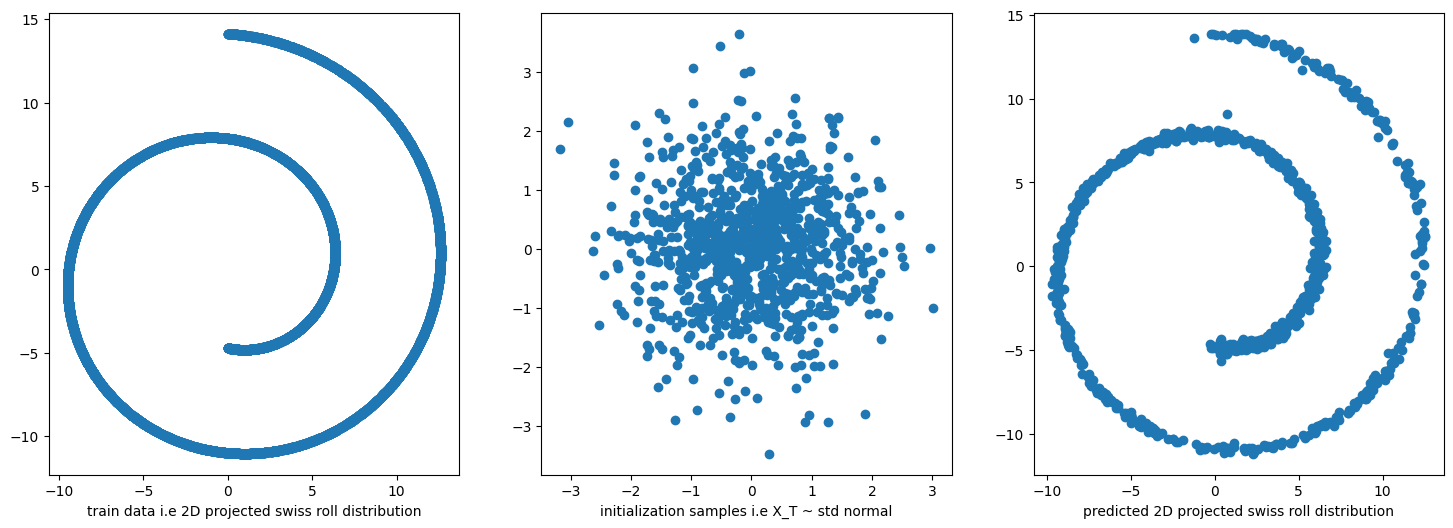

In [11]:
z = np.random.normal(loc=0, scale=1.0, size=(1000,3))
f, ax = plt.subplots(ncols=3, figsize=(18,6))
ax[0].scatter(X_train[:,0],X_train[:,2])
ax[0].set_xlabel('train data i.e 2D projected swiss roll distribution')
ax[1].scatter(z[:,0],z[:,2])
ax[1].set_xlabel('initialization samples i.e X_T ~ std normal')
pred_samples = []
for sample_id in range(len(z)):
    x = z[sample_id]
    for t in range(0,T):
        x = reverse_diffusion(ddpm_model=ddpm_model, x=x, t_curr=T-t, cuda=False, schedule=schedule, onlymean=False)
        assert x.shape == (3,)
    pred_samples.append(x)
pred_samples = np.stack(pred_samples,axis=0)
assert pred_samples.shape == z.shape
ax[2].scatter(pred_samples[:,0],pred_samples[:,2])
ax[2].set_xlabel('predicted 2D projected swiss roll distribution')